# Food Recommendation System Project

This project aims to build a recommender system using the Food.com Recipes and Reviews dataset. The dataset contains user reviews. 
This file aims :
- To get the dataset from Kaggle: [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews) and save it locally
- Generate a folder "dataset" and subfiles with the whole dataset, train and test datasets after splitting them using `Cornac`

In [1]:
import kagglehub
import os
import pandas as pd
import shutil

path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")

print("Path to dataset files:", path)

/home/abel/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/abel/.cache/kagglehub/datasets/irkaal/foodcom-recipes-and-reviews/versions/2


In [2]:
dataset_path = path
print('Files in dataset:', os.listdir(dataset_path))

Files in dataset: ['reviews.parquet', 'recipes.csv', 'reviews.csv', 'recipes.parquet']


In [3]:
data_folder = os.path.join(os.getcwd(), "data")
os.makedirs(data_folder, exist_ok=True)

# Copy all files from dataset_path to "data" folder
for filename in os.listdir(dataset_path):
    src = os.path.join(dataset_path, filename)
    dst = os.path.join(data_folder, filename)
    if os.path.isfile(src):
        shutil.copy2(src, dst)

print('Files in dataset:', os.listdir(dataset_path))
print('Files in data folder:', os.listdir(data_folder))

Files in dataset: ['reviews.parquet', 'recipes.csv', 'reviews.csv', 'recipes.parquet']
Files in data folder: ['reviews.parquet', 'recipes.csv', 'reviews.csv', 'recipes.parquet', 'clean_reviews.csv']


In [4]:
recipes_path = os.path.join(data_folder, "recipes.csv")
reviews_path = os.path.join(data_folder, "reviews.csv")

print("Recipes file path:", recipes_path)
print("Reviews file path:", reviews_path)

Recipes file path: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/recipes.csv
Reviews file path: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews.csv


## Clean dataset

As seen in the `data_analysis` file, some fields are not useful for our recommandation task and is limitating our application.

This is why we are going to clean our datasets to generate `clean_recipes.csv` (resp. `clean_reviews.csv`) to be handled by Cornac.

In [5]:
reviews = pd.read_csv(reviews_path)
reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


We check there are no rows with NaN in Rating field

In [6]:
print("Number of reviews before dropping NaN:", len(reviews))
reviews = reviews.dropna(subset=['Rating'])
print("Number of reviews after dropping NaN:", len(reviews))

Number of reviews before dropping NaN: 1401982
Number of reviews after dropping NaN: 1401982


We drop rows with missing AuthorId, RecipeId, or Rating as it cancel Reader from Cornac to work.


In [7]:
print("Number of reviews before dropping missing values:", len(reviews))
reviews = reviews.dropna(subset=['AuthorId', 'RecipeId', 'Rating'])
print("Number of reviews after dropping missing values:", len(reviews))

Number of reviews before dropping missing values: 1401982
Number of reviews after dropping missing values: 1401982


We drop useless columns as `DateSubmitted`, `DateModified`, `Review` and `AuthorName`

In [8]:
print("Number of columns in reviews:", len(reviews.columns))
reviews = reviews.drop(columns=['AuthorName', 'DateSubmitted', 'DateModified', 'Review'])
print("Number of columns in reviews after dropping some:", len(reviews.columns))


Number of columns in reviews: 8
Number of columns in reviews after dropping some: 4


We save this new clean reviews dataset

In [9]:
clean_reviews_path = os.path.join(data_folder, "clean_reviews.csv")
reviews.to_csv(clean_reviews_path, index=False)
print(f"Clean reviews saved to {clean_reviews_path}")

Clean reviews saved to /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/clean_reviews.csv


## Remove irrelevant items

With 1.4 million recipes in our dataset, applying recommendation systems becomes computationally expensive. To make our system more efficient while maintaining quality, we'll reduce the number of items to less than 50,000 using **K-core filtering**.

### What is K-core filtering?

K-core filtering (or K-core decomposition) is a technique used to filter items based on their connectivity in the user-item interaction graph. For our recommender system:

- **K-core(r)**: Keep only recipes that have at least K reviews
- This removes long-tail items with very few interactions
- Improves recommendation quality by focusing on items with sufficient user feedback
- Reduces computational complexity significantly

### Why use K-core filtering?

1. **Data Quality**: Items with very few reviews provide little information for collaborative filtering
2. **Cold Start Problem**: Items with few interactions are harder to recommend accurately  
3. **Computational Efficiency**: Smaller datasets train faster and use less memory
4. **Noise Reduction**: Removes potentially low-quality or unpopular items

We'll test different K values (5, 10, 15, 20, 25, 30) to find the optimal balance between dataset size and quality.



Original dataset size: 1401982 reviews
Number of unique recipes: 271678
Number of unique users: 271907

Recipe review distribution:
Min reviews per recipe: 1
Max reviews per recipe: 2892
Median reviews per recipe: 2.0
Mean reviews per recipe: 5.16


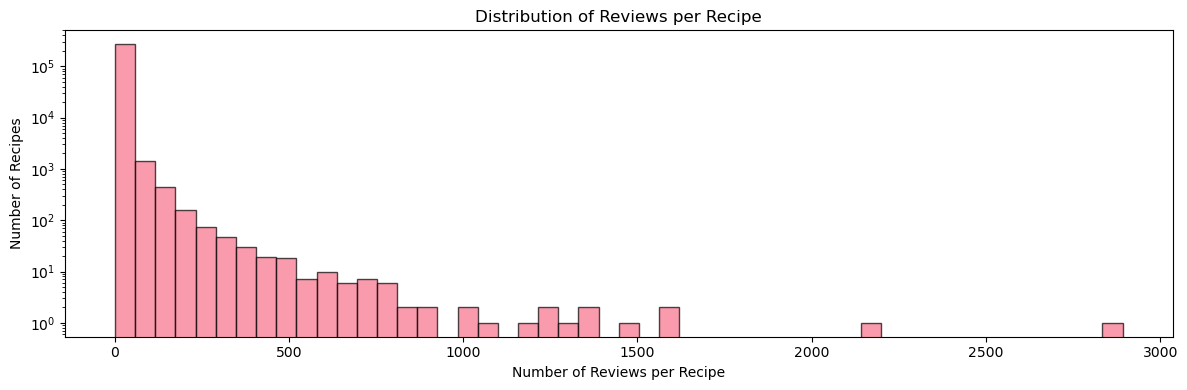

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('default')
sns.set_palette("husl")

# Load the clean reviews data
print(f"Original dataset size: {len(reviews)} reviews")
print(f"Number of unique recipes: {reviews['RecipeId'].nunique()}")
print(f"Number of unique users: {reviews['AuthorId'].nunique()}")

# Count reviews per recipe
recipe_review_counts = reviews['RecipeId'].value_counts()
print(f"\nRecipe review distribution:")
print(f"Min reviews per recipe: {recipe_review_counts.min()}")
print(f"Max reviews per recipe: {recipe_review_counts.max()}")
print(f"Median reviews per recipe: {recipe_review_counts.median()}")
print(f"Mean reviews per recipe: {recipe_review_counts.mean():.2f}")

# Show distribution of reviews per recipe
plt.figure(figsize=(12, 4))

plt.hist(recipe_review_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Reviews per Recipe')
plt.ylabel('Number of Recipes')
plt.title('Distribution of Reviews per Recipe')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [11]:
def iterative_kcore_filtering(df, min_user_ratings, min_item_ratings, max_iterations=100, verbose=True):
    """
    Apply iterative K-core filtering for both users and items
    
    Args:
        df: DataFrame with columns ['AuthorId', 'RecipeId', 'Rating']
        min_user_ratings: Minimum number of ratings per user
        min_item_ratings: Minimum number of ratings per recipe
        max_iterations: Maximum number of iterations to prevent infinite loops
        verbose: Whether to print progress
    
    Returns:
        Filtered DataFrame and iteration statistics
    """
    current_df = df.copy()
    iteration = 0
    stats = []
    
    while iteration < max_iterations:
        initial_shape = (current_df['AuthorId'].nunique(), current_df['RecipeId'].nunique(), len(current_df))
        
        # Filter recipes with insufficient ratings
        recipe_counts = current_df['RecipeId'].value_counts()
        valid_recipes = recipe_counts[recipe_counts >= min_item_ratings].index
        current_df = current_df[current_df['RecipeId'].isin(valid_recipes)]
        
        # Filter users with insufficient ratings
        user_counts = current_df['AuthorId'].value_counts()
        valid_users = user_counts[user_counts >= min_user_ratings].index
        current_df = current_df[current_df['AuthorId'].isin(valid_users)]
        
        final_shape = (current_df['AuthorId'].nunique(), current_df['RecipeId'].nunique(), len(current_df))
        
        stats.append({
            'iteration': iteration,
            'users': final_shape[0],
            'recipes': final_shape[1],
            'reviews': final_shape[2]
        })
        
        if verbose:
            print(f"Iteration {iteration}: {final_shape[0]} users, {final_shape[1]} recipes, {final_shape[2]} reviews")
        
        # Check convergence
        if initial_shape == final_shape:
            if verbose:
                print(f"Converged after {iteration + 1} iterations")
            break
            
        iteration += 1
    
    return current_df, stats

# Test different K values with iterative filtering
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]
results = []

print("Iterative K-core filtering results:")
print("=" * 80)
print(f"{'K Value':<8} {'Recipes':<10} {'Users':<10} {'Reviews':<12} {'Iterations':<12} {'Status':<15}")
print("=" * 80)

original_recipes = reviews['RecipeId'].nunique()
original_reviews = len(reviews)
original_users = reviews['AuthorId'].nunique()

# Target constraints
max_users = 50000
max_recipes = 50000

for k in k_values:
    # print(f"\nProcessing K={k}...")
    filtered_df, iteration_stats = iterative_kcore_filtering(
        reviews, 
        min_user_ratings=k, 
        min_item_ratings=k, 
        verbose=False
    )
    
    final_users = filtered_df['AuthorId'].nunique()
    final_recipes = filtered_df['RecipeId'].nunique()
    final_reviews = len(filtered_df)
    iterations_needed = len(iteration_stats)
    
    # Check if constraints are satisfied
    status = ""
    if final_users <= max_users and final_recipes <= max_recipes:
        status = "✓ GOOD"
    elif final_users > max_users and final_recipes > max_recipes:
        status = "✗ Both too high"
    elif final_users > max_users:
        status = "✗ Users too high"
    elif final_recipes > max_recipes:
        status = "✗ Recipes too high"
    
    results.append({
        'k': k,
        'users': final_users,
        'recipes': final_recipes,
        'reviews': final_reviews,
        'iterations': iterations_needed,
        'user_reduction': (1 - final_users / original_users) * 100,
        'recipe_reduction': (1 - final_recipes / original_recipes) * 100,
        'review_reduction': (1 - final_reviews / original_reviews) * 100,
        'iteration_stats': iteration_stats,
        'status': status
    })
    
    print(f"{k:<8} {final_recipes:<10} {final_users:<10} {final_reviews:<12} {iterations_needed:<12} {status:<15}")

print("\n" + "=" * 80)

Iterative K-core filtering results:
K Value  Recipes    Users      Reviews      Iterations   Status         
1        271678     271907     1401982      1            ✗ Both too high
2        151433     67874      1091378      5            ✗ Both too high
3        97053      39457      930697       5            ✗ Recipes too high
4        68103      28188      812670       5            ✗ Recipes too high
5        50835      21792      719687       6            ✗ Recipes too high
6        39057      17748      641730       6            ✓ GOOD         
7        30669      14828      574761       5            ✓ GOOD         
8        24632      12651      517982       6            ✓ GOOD         
9        20330      10965      470616       6            ✓ GOOD         
10       16850      9595       427460       6            ✓ GOOD         
12       12089      7505       356674       6            ✓ GOOD         
15       7800       5361       274854       7            ✓ GOOD         
20    

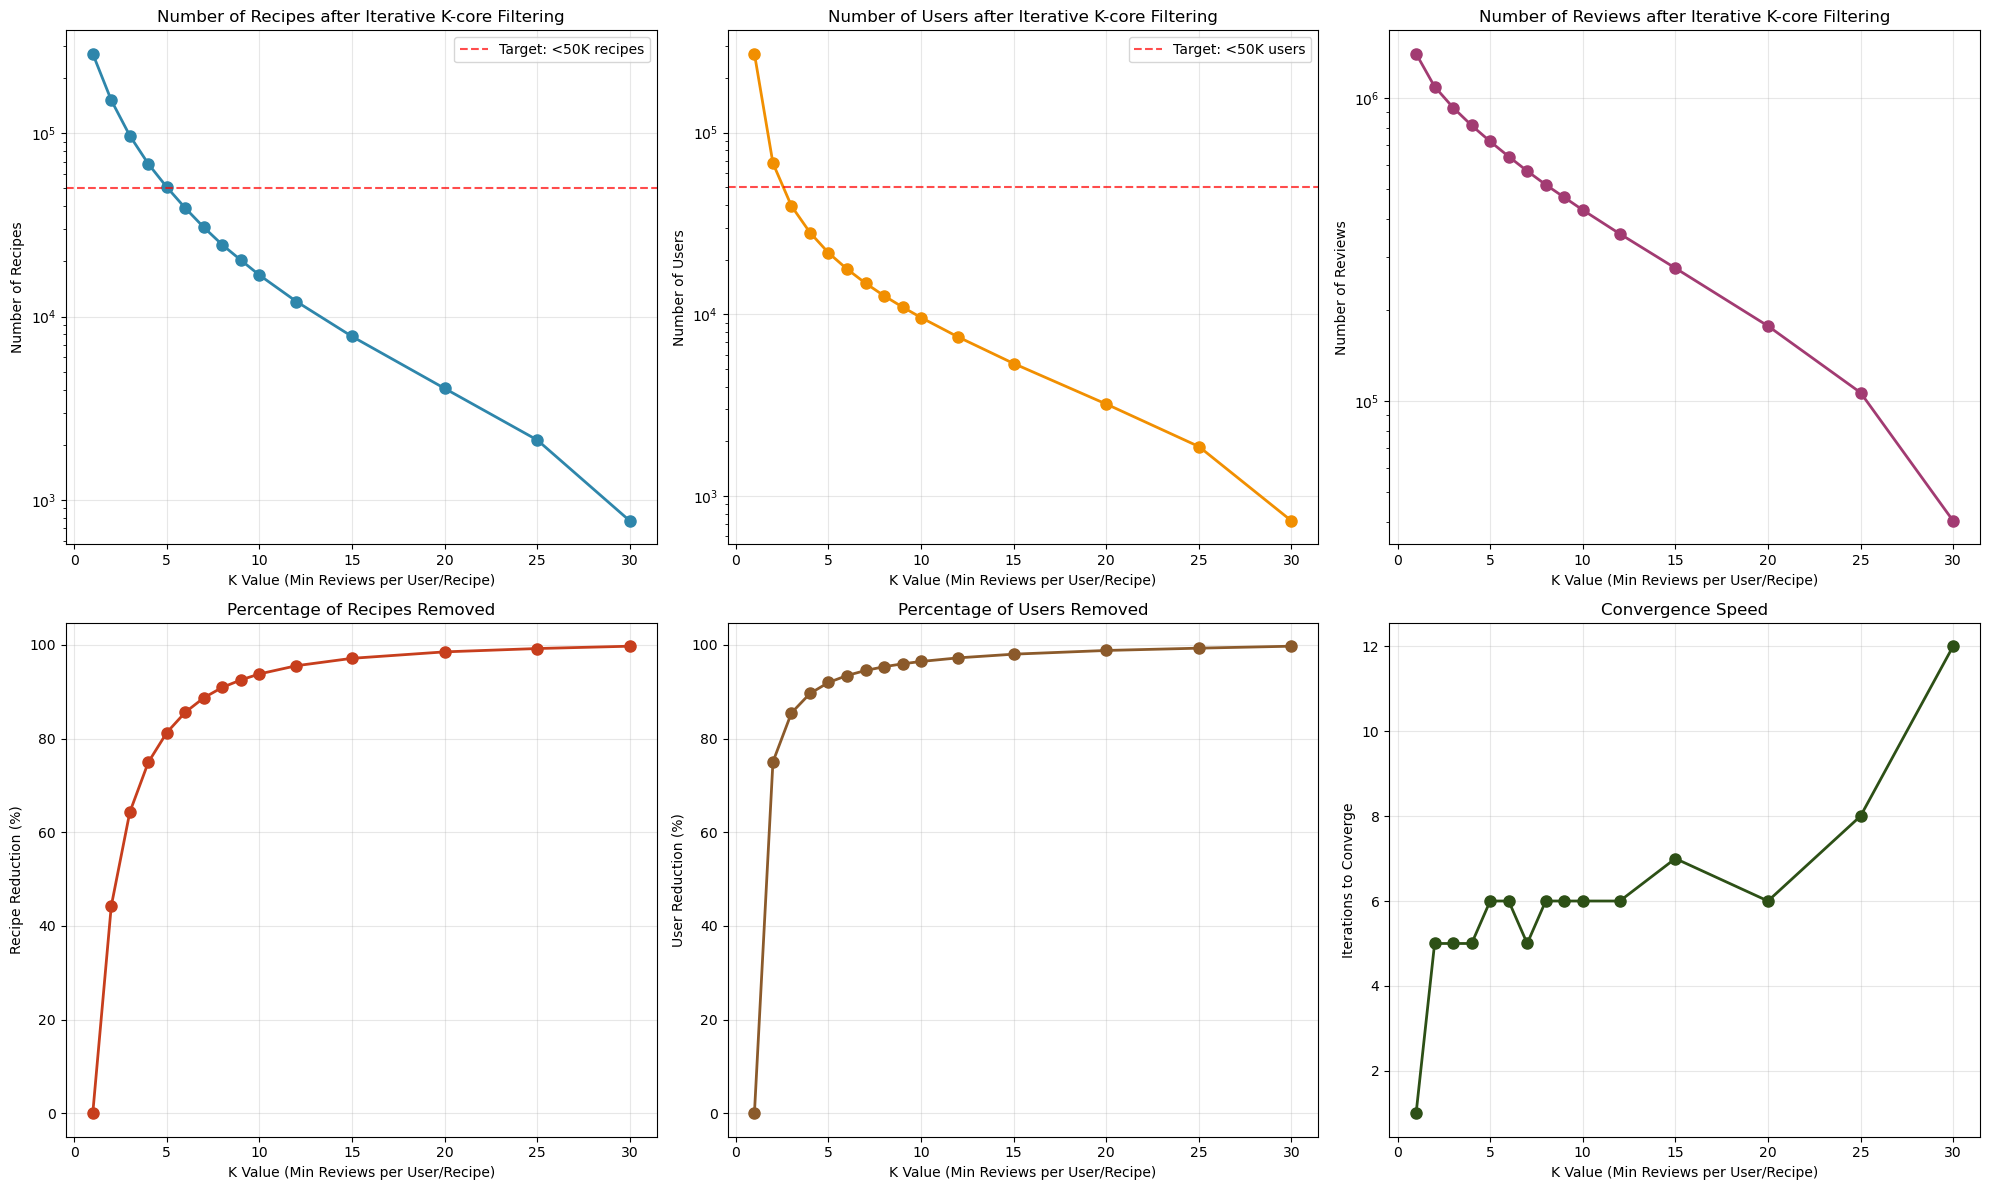


Detailed Statistics:
 K Value  Users  Recipes  Reviews  Iterations  User Reduction (%)  Recipe Reduction (%)  Review Reduction (%)             Status
       1 271907   271678  1401982           1                 0.0                   0.0                   0.0    ✗ Both too high
       2  67874   151433  1091378           5                75.0                  44.3                  22.2    ✗ Both too high
       3  39457    97053   930697           5                85.5                  64.3                  33.6 ✗ Recipes too high
       4  28188    68103   812670           5                89.6                  74.9                  42.0 ✗ Recipes too high
       5  21792    50835   719687           6                92.0                  81.3                  48.7 ✗ Recipes too high
       6  17748    39057   641730           6                93.5                  85.6                  54.2             ✓ GOOD
       7  14828    30669   574761           5                94.5          

In [12]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Extract data for plotting
k_vals = [r['k'] for r in results]
recipes_count = [r['recipes'] for r in results]
users_count = [r['users'] for r in results]
reviews_count = [r['reviews'] for r in results]
recipe_reduction = [r['recipe_reduction'] for r in results]
user_reduction = [r['user_reduction'] for r in results]
iterations_count = [r['iterations'] for r in results]

# Plot 1: Number of recipes vs K
axes[0, 0].plot(k_vals, recipes_count, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axhline(y=50000, color='red', linestyle='--', alpha=0.7, label='Target: <50K recipes')
axes[0, 0].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[0, 0].set_ylabel('Number of Recipes')
axes[0, 0].set_title('Number of Recipes after Iterative K-core Filtering')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Plot 2: Number of users vs K
axes[0, 1].plot(k_vals, users_count, 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[0, 1].axhline(y=50000, color='red', linestyle='--', alpha=0.7, label='Target: <50K users')
axes[0, 1].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('Number of Users after Iterative K-core Filtering')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_yscale('log')

# Plot 3: Number of reviews vs K
axes[0, 2].plot(k_vals, reviews_count, 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 2].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[0, 2].set_ylabel('Number of Reviews')
axes[0, 2].set_title('Number of Reviews after Iterative K-core Filtering')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_yscale('log')

# Plot 4: Recipe reduction percentage vs K
axes[1, 0].plot(k_vals, recipe_reduction, 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 0].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[1, 0].set_ylabel('Recipe Reduction (%)')
axes[1, 0].set_title('Percentage of Recipes Removed')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: User reduction percentage vs K
axes[1, 1].plot(k_vals, user_reduction, 'o-', linewidth=2, markersize=8, color='#8B5A2B')
axes[1, 1].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[1, 1].set_ylabel('User Reduction (%)')
axes[1, 1].set_title('Percentage of Users Removed')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Number of iterations needed vs K
axes[1, 2].plot(k_vals, iterations_count, 'o-', linewidth=2, markersize=8, color='#2D5016')
axes[1, 2].set_xlabel('K Value (Min Reviews per User/Recipe)')
axes[1, 2].set_ylabel('Iterations to Converge')
axes[1, 2].set_title('Convergence Speed')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create summary statistics DataFrame
import pandas as pd

stats_df = pd.DataFrame(results)
stats_df = stats_df[['k', 'users', 'recipes', 'reviews', 'iterations', 'user_reduction', 'recipe_reduction', 'review_reduction', 'status']]
stats_df.columns = ['K Value', 'Users', 'Recipes', 'Reviews', 'Iterations', 'User Reduction (%)', 'Recipe Reduction (%)', 'Review Reduction (%)', 'Status']

print("\nDetailed Statistics:")
print("=" * 120)
print(stats_df.to_string(index=False, float_format='%.1f'))

# Find optimal K values
valid_results = [r for r in results if r['users'] <= 50000 and r['recipes'] <= 50000]

if valid_results:
    print(f"\n\nValid K values that satisfy constraints (<50K users AND <50K recipes):")
    print("=" * 80)
    
    for result in valid_results:
        print(f"K={result['k']:2d}: {result['users']:6,} users, {result['recipes']:6,} recipes, {result['reviews']:8,} reviews")
        print(f"      Reductions: Users {result['user_reduction']:.1f}%, Recipes {result['recipe_reduction']:.1f}%, Reviews {result['review_reduction']:.1f}%")
        print(f"      Converged in {result['iterations']} iterations")
        print()
    
    # Recommend the K with the highest number of reviews (least aggressive)
    best_k = max(valid_results, key=lambda x: x['reviews'])
    print(f"RECOMMENDED K VALUE: {best_k['k']}")
    print(f"This preserves the most data while meeting constraints:")
    print(f"- {best_k['users']:,} users (reduction: {best_k['user_reduction']:.1f}%)")
    print(f"- {best_k['recipes']:,} recipes (reduction: {best_k['recipe_reduction']:.1f}%)")  
    print(f"- {best_k['reviews']:,} reviews (reduction: {best_k['review_reduction']:.1f}%)")
    print(f"- Converged in {best_k['iterations']} iterations")
    
    # Store the best result for later use
    optimal_k = best_k['k']
    
else:
    print(f"\n\nNo K value found that satisfies both constraints (<50K users AND <50K recipes).")
    print("You may need to increase the thresholds or use different filtering strategies.")

In [13]:
# Apply optimal K-core filtering and save dataset for Cornac
print("=" * 80)
print("PREPARING DATASET FOR CORNAC RECOMMENDER SYSTEMS")
print("=" * 80)

if 'optimal_k' in locals():
    print(f"Using optimal K value: {optimal_k}")
    
    # Apply the optimal k-core filtering
    final_filtered_df, final_stats = iterative_kcore_filtering(
        reviews, 
        min_user_ratings=optimal_k, 
        min_item_ratings=optimal_k, 
        verbose=False
    )
    
    print(f"\nFinal dataset statistics after K={optimal_k} filtering:")
    print(f"- Users: {final_filtered_df['AuthorId'].nunique():,}")
    print(f"- Recipes: {final_filtered_df['RecipeId'].nunique():,}")
    print(f"- Reviews: {len(final_filtered_df):,}")
    
    # Calculate sparsity
    sparsity = (1 - len(final_filtered_df) / (final_filtered_df['AuthorId'].nunique() * final_filtered_df['RecipeId'].nunique())) * 100
    print(f"- Sparsity: {sparsity:.2f}%")
    
    # Save the full k-core filtered dataset (before splitting) - for Cornac
    cornac_dataset_path = os.path.join(data_folder, f"reviews_dataset_k{optimal_k}.csv")
    final_filtered_df.to_csv(cornac_dataset_path, index=False)
    print(f"\n✓ Saved full k-core filtered dataset to: {cornac_dataset_path}")
    print(f"  This file contains {len(final_filtered_df):,} reviews and is ready for Cornac experiments")
    
    # Store for later use
    cornac_dataset = final_filtered_df.copy()
    
else:
    print("Warning: No optimal K found, using K=5 as fallback")
    optimal_k = 5
    
    final_filtered_df, final_stats = iterative_kcore_filtering(
        reviews, 
        min_user_ratings=optimal_k, 
        min_item_ratings=optimal_k, 
        verbose=False
    )
    
    cornac_dataset_path = os.path.join(data_folder, f"reviews_dataset_k{optimal_k}_fallback.csv")
    final_filtered_df.to_csv(cornac_dataset_path, index=False)
    print(f"\n✓ Saved fallback k-core filtered dataset to: {cornac_dataset_path}")
    
    cornac_dataset = final_filtered_df.copy()

print(f"\nDataset ready for Cornac recommender systems!")
print(f"File: {cornac_dataset_path}")
print(f"Shape: {cornac_dataset.shape}")
print(f"Columns: {list(cornac_dataset.columns)}")

PREPARING DATASET FOR CORNAC RECOMMENDER SYSTEMS
Using optimal K value: 6

Final dataset statistics after K=6 filtering:
- Users: 17,748
- Recipes: 39,057
- Reviews: 641,730
- Sparsity: 99.91%

✓ Saved full k-core filtered dataset to: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_dataset_k6.csv
  This file contains 641,730 reviews and is ready for Cornac experiments

Dataset ready for Cornac recommender systems!
File: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_dataset_k6.csv
Shape: (641730, 4)
Columns: ['ReviewId', 'RecipeId', 'AuthorId', 'Rating']


## Test and split data

In [14]:
import numpy as np
import os

def split_train_test(df, test_size=0.2, random_state=42, train_path=None, test_path=None):
    """
    Split dataset into train and test sets with optional saving
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_size)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]
    
    if train_path is not None:
        train_df.to_csv(train_path, index=False)
        print(f"✓ Train set saved to {train_path} ({len(train_df):,} rows)")
    if test_path is not None:
        test_df.to_csv(test_path, index=False)
        print(f"✓ Test set saved to {test_path} ({len(test_df):,} rows)")
    
    return train_df, test_df

# Split the k-core filtered dataset for Cornac experiments
print("=" * 60)
print("SPLITTING DATASET FOR TRAIN/TEST")
print("=" * 60)

if 'cornac_dataset' in locals():
    # Use the k-core filtered dataset
    dataset_to_split = cornac_dataset.copy()
    print(f"Using k-core filtered dataset with {len(dataset_to_split):,} reviews")
    
    # Define paths for train/test split
    train_path = os.path.join(data_folder, f"reviews_train_k{optimal_k}.csv")
    test_path = os.path.join(data_folder, f"reviews_test_k{optimal_k}.csv")
    
    # Split the dataset
    train_df, test_df = split_train_test(
        dataset_to_split, 
        test_size=0.2, 
        random_state=42, 
        train_path=train_path, 
        test_path=test_path
    )
    
    print(f"\nSplit completed:")
    print(f"- Train set: {len(train_df):,} reviews ({len(train_df)/len(dataset_to_split)*100:.1f}%)")
    print(f"- Test set: {len(test_df):,} reviews ({len(test_df)/len(dataset_to_split)*100:.1f}%)")
    print(f"- Total: {len(train_df) + len(test_df):,} reviews")
    
    # Verify split consistency
    print(f"\nTrain set statistics:")
    print(f"- Users: {train_df['AuthorId'].nunique():,}")
    print(f"- Recipes: {train_df['RecipeId'].nunique():,}")
    
    print(f"\nTest set statistics:")
    print(f"- Users: {test_df['AuthorId'].nunique():,}")
    print(f"- Recipes: {test_df['RecipeId'].nunique():,}")
    
else:
    print("Error: No k-core filtered dataset found. Please run the k-core filtering first.")
    train_df = None
    test_df = None

SPLITTING DATASET FOR TRAIN/TEST
Using k-core filtered dataset with 641,730 reviews
✓ Train set saved to /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_train_k6.csv (513,384 rows)
✓ Test set saved to /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_test_k6.csv (128,346 rows)

Split completed:
- Train set: 513,384 reviews (80.0%)
- Test set: 128,346 reviews (20.0%)
- Total: 641,730 reviews

Train set statistics:
- Users: 17,748
- Recipes: 39,057

Test set statistics:
- Users: 16,131
- Recipes: 34,075


In [15]:
print("Size of train set:", len(train_df))
print("Size of test set:", len(test_df))
print("Size of total dataset:", len(reviews), " == Size of train set + Size of test set:", len(train_df) + len(test_df))

# Print detailed statistics and verify the split
if train_df is not None and test_df is not None:
    print("\n" + "=" * 60)
    print("FINAL DATASET SUMMARY FOR CORNAC")
    print("=" * 60)
    
    print(f"Original dataset: {len(reviews):,} reviews")
    print(f"After K={optimal_k} filtering: {len(cornac_dataset):,} reviews")
    print(f"Reduction: {(1 - len(cornac_dataset)/len(reviews))*100:.1f}%")
    
    print(f"\nTrain set: {len(train_df):,} reviews")
    print(f"Test set: {len(test_df):,} reviews") 
    print(f"Total split: {len(train_df) + len(test_df):,} reviews")
    
    # Verify no data loss
    assert len(train_df) + len(test_df) == len(cornac_dataset), "Data loss detected in split!"
    print("✓ Split verification: No data loss detected")
    
    print(f"\nFiles created for Cornac:")
    print(f"1. Full dataset: {cornac_dataset_path}")
    print(f"2. Train set: {train_path}")
    print(f"3. Test set: {test_path}")    
else:
    print("Error: Train/test split failed. Please check the k-core filtering step.")

Size of train set: 513384
Size of test set: 128346
Size of total dataset: 1401982  == Size of train set + Size of test set: 641730

FINAL DATASET SUMMARY FOR CORNAC
Original dataset: 1,401,982 reviews
After K=6 filtering: 641,730 reviews
Reduction: 54.2%

Train set: 513,384 reviews
Test set: 128,346 reviews
Total split: 641,730 reviews
✓ Split verification: No data loss detected

Files created for Cornac:
1. Full dataset: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_dataset_k6.csv
2. Train set: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_train_k6.csv
3. Test set: /home/abel/epita/recomendation_system/Recommandation-Benchmark-for-Recipes/data/reviews_test_k6.csv
